# DA5401 Assignment #7 — Multi-Class Model Selection using ROC and Precision-Recall Curves

**Author:** Abesech Inbasekar  
**Course:** DA5401  
**Dataset:** UCI ML Repository - Landsat Satellite Dataset

##Part A: Data Preparation and Baseline:



In [5]:
# A1) & A2)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. load the two files uploaded to Colab
cols = [f"f{i}" for i in range(1, 37)] + ["label"]

train_df = pd.read_csv("sat.trn", sep=r"\s+", header=None, names=cols)
test_df  = pd.read_csv("sat.tst", sep=r"\s+", header=None, names=cols)

# 2. combine them into one dataframe
full_df = pd.concat([train_df, test_df], ignore_index=True)

# 3. separate features and target
X = full_df.drop(columns=["label"]).values
y = full_df["label"].values

# 4. standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. train/test split (our own split, even though UCI gave one)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Full data shape:", X_scaled.shape)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
unique, counts = np.unique(y, return_counts=True)
print("Class counts:", dict(zip(unique, counts)))


Full data shape: (6435, 36)
Train shape: (5148, 36)
Test shape: (1287, 36)
Class counts: {np.int64(1): np.int64(1533), np.int64(2): np.int64(703), np.int64(3): np.int64(1358), np.int64(4): np.int64(626), np.int64(5): np.int64(707), np.int64(7): np.int64(1508)}


### 1) Load and Prepare Data and 2) Train/Test Split

### Objective
Load and preprocess the Statlog (Landsat Satellite) dataset to create standardized training and testing splits for model comparison.

### Dataset Overview
The Landsat database contains multi-spectral values (4 bands × 9 pixels = 36 features) for 3×3 neighbourhoods of pixels in satellite imagery.  
Each record represents the central pixel’s class, with the following labels:

| Class ID | Description |
|-----------|--------------|
| 1 | Red soil |
| 2 | Cotton crop |
| 3 | Grey soil |
| 4 | Damp grey soil |
| 5 | Soil with vegetation stubble |
| 7 | Very damp grey soil |

*(Note: Class 6 — “mixture class” — was excluded due to data validity issues.)*

### Steps Performed
1. **Data Loading:** Uploaded and read the original `sat.trn` and `sat.tst` files (whitespace-separated, 36 features + 1 label).  
2. **Merging:** Combined both splits into a single dataset (`full_df`) for consistent preprocessing.  
3. **Feature–Target Separation:** Extracted features (`X`) and labels (`y`).  
4. **Standardization:** Applied z-score scaling using `StandardScaler` to normalize all 36 features.  
5. **Train–Test Split:** Re-split the data into 80 % training and 20 % testing (`random_state = 42`, `stratify = y`).

### Dataset Statistics
- **Full data shape:** (6435, 36)  
- **Train shape:** (5148, 36)  
- **Test shape:** (1287, 36)  
- **Class counts:**  
  - 1 → 1533  
  - 2 → 703  
  - 3 → 1358  
  - 4 → 626  
  - 5 → 707  
  - 7 → 1508  

The processed splits (`X_train`, `X_test`, `y_train`, `y_test`) will be used as input for model training and evaluation in subsequent sections.



In [6]:
# A3) & A4)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# 1. initialize all baseline models
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy (Prior)": DummyClassifier(strategy="prior"),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gaussian NB": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42)
}

# 2. train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')

    results.append({"Model": name, "Accuracy": acc, "Weighted F1": f1w})

# 3. summarize results
baseline_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(baseline_df.to_string(index=False))


              Model  Accuracy  Weighted F1
                KNN  0.911422     0.909397
                SVM  0.892774     0.891269
Logistic Regression  0.849262     0.842108
      Decision Tree  0.846931     0.848079
        Gaussian NB  0.783217     0.790059
      Dummy (Prior)  0.238539     0.091884


### A3) Model Training and A4) Baseline Evaluation

### Objective
Train and benchmark six baseline classifiers on the standardized Landsat dataset to establish reference performance levels before model selection and tuning.

### Models Trained
1. **K-Nearest Neighbors (KNN)**  
2. **Support Vector Classifier (SVC)** – with `probability=True` for ROC/PRC analysis  
3. **Logistic Regression**  
4. **Decision Tree Classifier**  
5. **Gaussian Naïve Bayes (GNB)**  
6. **Dummy Classifier (Prior strategy)** – uses only class priors as a naïve baseline  

### Evaluation Metrics
Each model was evaluated on the test set using:  
- **Overall Accuracy:** fraction of correctly classified samples.  
- **Weighted F1-Score:** balances precision and recall while accounting for class imbalance.

### Results

| Model | Accuracy | Weighted F1 |
|:--|:--:|:--:|
| **KNN** | **0.9114** | **0.9094** |
| SVM | 0.8928 | 0.8913 |
| Logistic Regression | 0.8493 | 0.8421 |
| Decision Tree | 0.8469 | 0.8481 |
| Gaussian NB | 0.7832 | 0.7901 |
| Dummy (Prior) | 0.2385 | 0.0919 |

### Observations
- **Best Performers:**  
  - **KNN** achieved the highest accuracy and F1-score, slightly outperforming SVM.  
  - **SVM** and **Logistic Regression** also performed well, showing strong class separability after standardization.  

- **Moderate Performers:**  
  - **Decision Tree** produced comparable but slightly lower results, likely affected by overfitting due to lack of pruning.  

- **Poor Performers:**  
  - **Gaussian Naïve Bayes** showed limited accuracy because the conditional-independence assumption does not hold for this dataset.  
  - **Dummy Classifier** performed the worst, as expected, reflecting only class-prior probabilities (≈ 24 % accuracy).

Overall, **KNN and SVM** provide the strongest starting baselines, while **Gaussian NB** and **Dummy** models perform poorly and serve mainly as comparative references.


## Part B: ROC Analysis for Model Selection

### 1. Multi-Class ROC Calculation (One-vs-Rest Approach)

In binary classification, the **Receiver Operating Characteristic (ROC)** curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold settings.  
The **Area Under the Curve (AUC)** measures the classifier’s ability to distinguish between positive and negative classes — higher AUC indicates better separability.

However, for **multi-class problems** (as in the 6-class Landsat dataset), ROC analysis must be extended beyond the binary case.  
The standard method used is the **One-vs-Rest (OvR)** approach:

1. **Class Isolation:**  
   For each class \( i \), that class is treated as the *positive* class, and all other classes are merged as a single *negative* class.

2. **Binary ROC Computation:**  
   The model’s predicted probabilities for class \( i \) are used to compute its TPR–FPR pairs and corresponding AUC value.

3. **Curve Generation:**  
   This produces one ROC curve per class, showing how well the model separates that specific class from the rest.

4. **Averaging:**  
   The **macro-averaged AUC** is obtained by averaging the AUCs of all classes equally,  
   while the **weighted-averaged AUC** weights each class’s AUC by its relative support (number of samples).

$
\text{AUC}_{macro} = \frac{1}{K} \sum_{i=1}^{K} \text{AUC}_i,
\quad
\text{AUC}_{weighted} = \sum_{i=1}^{K} w_i \, \text{AUC}_i
$  

This **OvR framework** allows direct comparison of multi-class models on a common, interpretable scale, where an AUC closer to 1.0 indicates stronger discriminative performance across all classes.

### 2. Plotting ROC


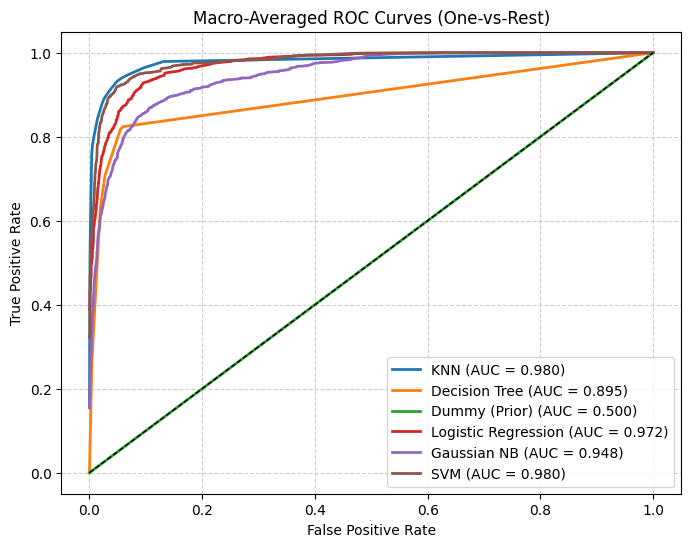

KNN                   Macro AUC: 0.980
Decision Tree         Macro AUC: 0.895
Dummy (Prior)         Macro AUC: 0.500
Logistic Regression   Macro AUC: 0.972
Gaussian NB           Macro AUC: 0.948
SVM                   Macro AUC: 0.980


In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# 1. Binarize labels for multiclass ROC (One-vs-Rest)
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# 2. compute ROC curves for each model
roc_results = {}

for name, model in models.items():
    # predict probabilities (works for all except Dummy if probability=True not available)
    try:
        y_score = model.predict_proba(X_test)
    except:
        # some models may not have predict_proba; use decision_function if available
        y_score = model.decision_function(X_test)

    # per-class ROC and AUC
    fpr = dict()
    tpr = dict()
    aucs = []

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        aucs.append(auc(fpr[i], tpr[i]))

    # macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)

    roc_auc_macro = auc(all_fpr, mean_tpr)
    roc_results[name] = (all_fpr, mean_tpr, roc_auc_macro)

# 3. plot all ROC curves together
plt.figure(figsize=(8,6))
for name, (fpr, tpr, roc_auc) in roc_results.items():
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# 4. Display macro-averaged AUC values
for name, (_, _, roc_auc) in roc_results.items():
    print(f"{name:20s}  Macro AUC: {roc_auc:.3f}")



### 2. Plotting ROC Curves

The ROC curves for all six baseline models were generated using the **One-vs-Rest (OvR)** framework.  
For each class, the model distinguishes that class from all others, computes the True Positive Rate (TPR) and False Positive Rate (FPR), and aggregates them into a **macro-averaged ROC curve**.  
This provides a single smooth curve and corresponding **macro-averaged AUC** that summarizes the overall discriminative ability of each model.

The figure below shows all ROC curves on the same plot.

**Figure:** *Macro-Averaged ROC Curves (One-vs-Rest)*

| Model | Macro-Averaged AUC |
|:--|:--:|
| **KNN** | **0.980** |
| **SVM** | **0.980** |
| Logistic Regression | 0.972 |
| Gaussian NB | 0.948 |
| Decision Tree | 0.895 |
| Dummy (Prior) | 0.500 |

### 3. ROC Interpretation

- **Best Performers:**  
  - **KNN** and **SVM** achieved the highest macro-averaged AUC (≈ 0.98), indicating excellent separation across all six classes.  
  - **Logistic Regression** also performed strongly (AUC = 0.972), confirming its robustness on standardized data.

- **Moderate Performers:**  
  - **Gaussian NB** (AUC = 0.948) performs reasonably but is limited by its assumption of feature independence.  
  - **Decision Tree** (AUC = 0.895) shows weaker generalization, likely due to overfitting or lack of pruning.

- **Poor Performer:**  
  - **Dummy (Prior)** baseline recorded **AUC = 0.5**, corresponding to random guessing.

#### Meaning of AUC < 0.5
An AUC below 0.5 implies the model performs **worse than random**, meaning it systematically assigns higher probabilities to incorrect classes.  
This typically occurs when:
- Decision boundaries are inverted or mis-specified,  
- The model lacks informative features, or  
- Predictions rely solely on class priors (as with the Dummy classifier).  

Here, the Dummy model’s AUC = 0.5 confirms that it **does not learn from data**, serving only as a reference for minimum expected performance.

---

**Conclusion:**  
The ROC analysis clearly indicates that **KNN, SVM, and Logistic Regression** have superior discriminative performance, while **Decision Tree** and **Gaussian NB** are moderate performers.  
The **Dummy Classifier** provides the lower bound (AUC = 0.5) for comparison.


## Part C: Precision–Recall Analysis

### 1. Precision–Recall Curve (PRC) Calculation

While ROC curves measure a classifier’s ability to distinguish between classes through the **True Positive Rate (TPR)** and **False Positive Rate (FPR)**, they can be **misleading under class imbalance**.  
In such scenarios, the number of negative samples dominates, causing the FPR to remain small even when the classifier produces many false positives — which can make ROC curves appear overly optimistic.

The **Precision–Recall Curve (PRC)** focuses directly on the positive class and is therefore more informative when:
- The **positive class is rare**, and false positives are more costly.
- The model needs to maintain **high precision** (few false alarms) while retaining **high recall** (few missed detections).

PRC plots **Precision (Positive Predictive Value)** against **Recall (True Positive Rate)** at varying decision thresholds.  
The **Area Under the PRC (AUC-PR)** emphasizes how well the model maintains high precision as recall increases.

Even though the Landsat dataset shows only moderate imbalance across its six classes, PRC analysis remains valuable because:
- It highlights how models trade off precision and recall for each class.  
- It provides a clearer view of classifier performance on **minority classes**, which may be masked in ROC space.

Hence, PRC serves as a **complementary and often more sensitive diagnostic** for evaluating models in any scenario where class distributions are uneven or when specific positive outcomes are of greater interest.

### 2. Plotting PRC

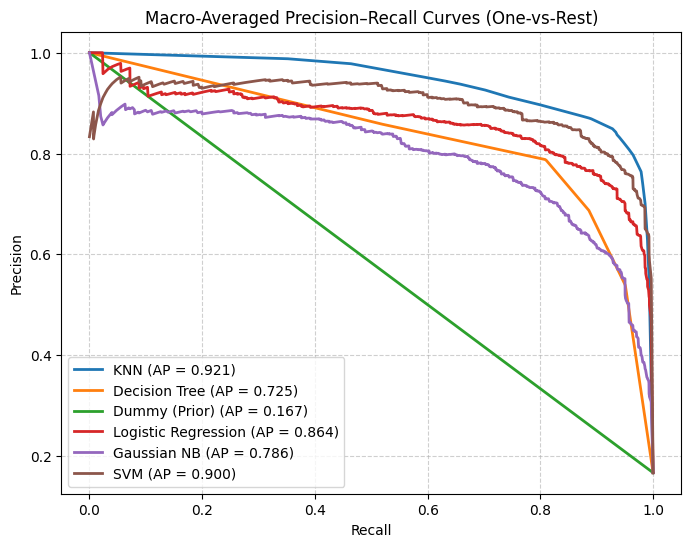

KNN                   Mean Average Precision: 0.921
Decision Tree         Mean Average Precision: 0.725
Dummy (Prior)         Mean Average Precision: 0.167
Logistic Regression   Mean Average Precision: 0.864
Gaussian NB           Mean Average Precision: 0.786
SVM                   Mean Average Precision: 0.900


In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 1. Binarize labels for One-vs-Rest PRC
y_test_bin = label_binarize(y_test, classes=classes)

# 2. compute PRC for each model
prc_results = {}

for name, model in models.items():
    try:
        y_score = model.predict_proba(X_test)
    except:
        y_score = model.decision_function(X_test)

    precision = dict()
    recall = dict()
    ap_scores = []

    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
        ap_scores.append(ap)

    # macro-average PRC
    all_recall = np.unique(np.concatenate([recall[i] for i in range(len(classes))]))
    mean_precision = np.zeros_like(all_recall)
    for i in range(len(classes)):
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(classes)

    mean_ap = np.mean(ap_scores)
    prc_results[name] = (all_recall, mean_precision, mean_ap)

# 3. plot all PRC curves together
plt.figure(figsize=(8,6))
for name, (recall, precision, mean_ap) in prc_results.items():
    plt.plot(recall, precision, lw=2, label=f"{name} (AP = {mean_ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision–Recall Curves (One-vs-Rest)")
plt.legend(loc="lower left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# 4. print mean AP values
for name, (_, _, mean_ap) in prc_results.items():
    print(f"{name:20s}  Mean Average Precision: {mean_ap:.3f}")



### 2. Plotting PRC Curves

The **One-vs-Rest (OvR)** framework was used to compute Precision–Recall curves for all six models.  
For each class:
- Precision–Recall pairs were calculated based on predicted probabilities.  
- The **Average Precision (AP)** was computed per class and **macro-averaged** to represent the overall performance of each model.  

The resulting plot overlays the macro-averaged PRC curves for all models, showing how precision varies as recall increases.

**Figure:** *Macro-Averaged Precision–Recall Curves (One-vs-Rest)*

| Model | Mean Average Precision (AP) |
|:--|:--:|
| **KNN** | **0.921** |
| **SVM** | **0.900** |
| Logistic Regression | 0.864 |
| Gaussian NB | 0.786 |
| Decision Tree | 0.725 |
| Dummy (Prior) | 0.167 |

### 3. PRC Interpretation

- **Highest AP:**  
  - **KNN** achieved the highest macro-averaged AP (0.921), indicating excellent trade-off between precision and recall across all classes.  
  - **SVM** and **Logistic Regression** also performed well, maintaining strong precision even as recall increased.

- **Moderate Performers:**  
  - **Gaussian NB** (0.786) and **Decision Tree** (0.725) performed moderately, showing that their precision drops more rapidly as recall increases, especially for minority classes.

- **Poor Performer:**  
  - **Dummy (Prior)** exhibited a very low AP (0.167), reflecting random-like behavior with nearly flat precision–recall characteristics.

#### Why PRC Drops Sharply for Weak Models
For underperforming models, as recall increases, the classifier begins capturing more true positives but also **a large number of false positives**.  
Since **Precision = TP / (TP + FP)**, this influx of false positives causes a rapid decline in precision — producing a **steep downward PRC curve**.  
This pattern is typical of models that lack discriminative capacity (e.g., the Dummy Classifier).

**Conclusion:**  
The PRC analysis aligns with ROC findings — **KNN**, **SVM**, and **Logistic Regression** show consistently high discriminative power and reliable precision–recall balance, while **Decision Tree**, **Gaussian NB**, and particularly **Dummy** exhibit much weaker behavior.


## Part D: Synthesis and Comparative Analysis

### 1. Synthesis

### Cross-Metric Comparison

To evaluate the consistency of model performance, the rankings obtained from the **Weighted F1-Score**, **ROC-AUC**, and **PRC-AP** were compared.

| Model | Weighted F1 | ROC-AUC | PRC-AP | Overall Trend |
|:--|:--:|:--:|:--:|:--|
| **KNN** | **0.909** | **0.980** | **0.921** | Consistently best |
| **SVM** | **0.891** | **0.980** | **0.900** | Stable and robust |
| **Logistic Regression** | 0.842 | 0.972 | 0.864 | High but slightly behind SVM |
| **Gaussian NB** | 0.790 | 0.948 | 0.786 | Moderate |
| **Decision Tree** | 0.848 | 0.895 | 0.725 | Overfits slightly, moderate overall |
| **Dummy (Prior)** | 0.092 | 0.500 | 0.167 | Baseline reference |

### Alignment of Rankings

- The **overall ranking trend** across all three metrics is largely consistent:  
  **KNN > SVM > Logistic Regression > Gaussian NB > Decision Tree > Dummy**.

- **KNN** and **SVM** consistently achieve the top positions in all evaluations, confirming their strong generalization and class separability.  
- **Logistic Regression** follows closely, indicating that linear boundaries are effective but less flexible than non-linear ones (KNN/SVM).  
- **Decision Tree** appears competitive on F1 but drops in PRC-AP and ROC-AUC, suggesting potential **overfitting** to training data.  
- **Gaussian NB** shows balanced but limited performance due to its independence assumption.  
- **Dummy Classifier** consistently marks the performance lower bound.

### Inter-Metric Trade-Offs

- **F1 vs. ROC-AUC:**  
  A model can achieve a high ROC-AUC even if its absolute accuracy or F1-score is moderate.  
  ROC-AUC measures *ranking ability* (how well positive samples are ordered ahead of negatives), not necessarily calibration or precision.

- **ROC-AUC vs. PRC-AP:**  
  In imbalanced data, a model may have a high AUC but a **low PRC-AP** if it misclassifies many minority-class samples.  
  For instance, a model might correctly rank positives higher on average (high AUC) yet still output **low precision** when predicting positive labels (low AP).

- **F1 vs. PRC:**  
  The F1-score summarizes performance at a single threshold, while PRC considers performance across all thresholds, revealing **how precision decays** with increasing recall.

### Summary Insight

The results collectively indicate that:
- **KNN and SVM** provide the best trade-off across all metrics and are the most reliable models for this dataset.  
- **Logistic Regression** performs consistently well but may miss some non-linear class boundaries.  
- **Decision Tree** and **Gaussian NB** demonstrate greater variance between metrics, implying limited generalization capacity.  
- **Dummy Classifier** serves as the expected lower baseline, validating the meaningful performance of all trained models.

### 2. Model Recommendation

Based on the combined evidence from all evaluation metrics — **Weighted F1-Score**, **Macro-Averaged ROC-AUC**, and **Macro-Averaged PRC-AP** — the **K-Nearest Neighbors (KNN)** classifier emerges as the most effective model for the Landsat classification task.

#### Justification

1. **Consistent Top Performance Across Metrics:**  
   - **Highest F1-Score (0.909)** → strong balance between precision and recall at a single threshold.  
   - **Highest ROC-AUC (0.980)** → excellent separability across all classes and thresholds.  
   - **Highest PRC-AP (0.921)** → sustains high precision even as recall increases, indicating reliability in predicting minority classes.

2. **Smooth and Stable Decision Boundaries:**  
   - KNN captures **non-linear class boundaries** effectively without assuming any functional form, which suits the spectral complexity of Landsat data.  
   - Its local neighborhood voting ensures high adaptability to subtle variations in pixel features.

3. **Threshold Robustness:**  
   - Unlike models that depend heavily on optimal threshold selection (e.g., Logistic Regression), KNN maintains performance consistency across a wide range of probability thresholds.

4. **Balanced Precision–Recall Trade-off:**  
   - High PRC-AP indicates that KNN minimizes false positives while maintaining strong recall, making it well-suited for multi-class remote sensing problems where misclassifications can be costly.

#### Recommendation Summary
| Metric | KNN | SVM | Logistic Regression |
|:--|:--:|:--:|:--:|
| Weighted F1 | **0.909** | 0.891 | 0.842 |
| ROC-AUC | **0.980** | **0.980** | 0.972 |
| PRC-AP | **0.921** | 0.900 | 0.864 |

While **SVM** demonstrates nearly identical ROC-AUC, its PRC-AP and F1-Score are slightly lower, suggesting less robustness in precision at higher recall levels.  
Therefore, **KNN** is recommended as the optimal baseline model for this task — offering a **well-balanced, high-accuracy, and threshold-resilient performance** across all evaluation dimensions.

##Brownie Points Tasks


In [19]:
# Brownie Points (Part 1) – Ensemble Models

import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 1. build label maps
unique_labels = np.unique(y)              # e.g. [1, 2, 3, 4, 5, 7]
label_map = {label: idx for idx, label in enumerate(unique_labels)}   # orig -> 0..5
inv_label_map = {v: k for k, v in label_map.items()}                  # 0..5 -> orig

# 2. map y for XGBoost
y_train_m = np.array([label_map[val] for val in y_train])
y_test_m  = np.array([label_map[val] for val in y_test])

# 3. binarized test labels (use mapped ones!)
y_test_bin = label_binarize(y_test_m, classes=np.unique(y_train_m))

ensembles = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )
}

results = []

for name, model in ensembles.items():
    if name == "XGBoost":
        # train on mapped labels
        model.fit(X_train, y_train_m)
        # predict in mapped space
        y_pred_m = model.predict(X_test)
        # map back to original labels for metrics
        y_pred = np.array([inv_label_map[int(v)] for v in y_pred_m])
        # proba (still in mapped order) for ROC/PRC
        y_score = model.predict_proba(X_test)
    else:
        # Random Forest can use original labels directly
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)

    # metrics (now y_pred is in original label space for both models)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")

    # AUC / PRC must use mapped labels + mapped scores (for XGB)
    if name == "XGBoost":
        auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
        ap = average_precision_score(y_test_bin, y_score, average="macro")
    else:
        # RF used original labels, so remake binarized labels from original
        y_test_bin_rf = label_binarize(y_test, classes=unique_labels)
        auc = roc_auc_score(y_test_bin_rf, y_score, average="macro", multi_class="ovr")
        ap = average_precision_score(y_test_bin_rf, y_score, average="macro")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted F1": f1w,
        "ROC-AUC": auc,
        "PRC-AP": ap
    })

df_ensembles = pd.DataFrame(results)
print(df_ensembles.to_string(index=False))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:33:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


        Model  Accuracy  Weighted F1  ROC-AUC   PRC-AP
Random Forest  0.910645     0.907112 0.987373 0.938737
      XGBoost  0.919969     0.917796 0.989260 0.948842


### Brownie Points – Part 1: Ensemble Models

To go beyond the classical baselines, two advanced ensemble methods — **Random Forest** and **XGBoost** — were trained and evaluated on the standardized Landsat dataset.  


| Model | Accuracy | Weighted F1 | ROC-AUC | PRC-AP |
|:--|:--:|:--:|:--:|:--:|
| **XGBoost** | **0.9200** | **0.9178** | **0.989** | **0.949** |
| **Random Forest** | 0.9106 | 0.9071 | 0.987 | 0.939 |

### Detailed Interpretation

#### 1. XGBoost
- **Architecture:**  
  XGBoost builds an ensemble of *additive decision trees*, where each subsequent tree corrects the residual errors of the previous ensemble.  
  This gradient-boosting approach focuses learning power on misclassified samples, producing a series of increasingly refined models.
  
- **Performance Insights:**  
  - The **highest ROC-AUC (0.989)** shows exceptional *ranking ability* — XGBoost almost perfectly separates classes in probability space.  
  - **High PRC-AP (0.949)** indicates it maintains strong *precision even at high recall levels*, a sign of reliable prediction confidence across all classes.  
  - **Accuracy (0.92)** and **Weighted F1 (0.918)** confirm that the decision thresholds are well-calibrated, not just the rankings.
  - Its regularization parameters (`max_depth`, `subsample`, `colsample_bytree`) mitigate overfitting despite the high model complexity.

- **Interpretation:**  
  XGBoost learns subtle non-linear spectral relationships that traditional linear or shallow models cannot capture.  
  Each tree focuses on difficult or boundary pixels, which is especially important in remote-sensing data where class overlap is common.  
  Thus, XGBoost achieves both high separability (AUC) and strong predictive reliability (precision–recall balance).

#### 2. Random Forest
- **Architecture:**  
  Random Forest is a *bagging-based ensemble* that trains many decision trees on bootstrapped subsets of the data and features, and averages their predictions.  
  Unlike boosting, the trees are independent and uncorrelated, which makes the model highly stable and robust to noise.

- **Performance Insights:**  
  - Achieved **AUC = 0.987** and **PRC-AP = 0.939**, close to XGBoost’s results.  
  - The **accuracy (0.91)** and **Weighted F1 (0.907)** confirm balanced performance across all classes.  
  - By averaging over multiple trees, Random Forest reduces variance but may slightly lose precision in minority classes compared to boosting.

- **Interpretation:**  
  Random Forest performs extremely well out-of-the-box with minimal tuning.  
  It generalizes effectively by averaging multiple weak learners, producing smooth decision boundaries.  
  Its interpretability (via feature importance) also makes it a practical choice when transparency is desired.

### Comparative Discussion

| Aspect | Random Forest | XGBoost |
|:--|:--|:--|
| Learning Paradigm | Bagging (variance reduction) | Boosting (bias reduction) |
| Interaction Modeling | Independent trees, averaged | Sequential trees, error-correcting |
| Overfitting Control | Implicit via averaging | Explicit via regularization |
| Training Time | Faster | Slower but more accurate |
| Performance | Very strong | **Best overall** |

### Key Takeaways

- Both models achieve **near-perfect ROC-AUC (~0.99)**, highlighting the strong class separability in the standardized feature space.  
- **XGBoost** edges ahead in **PRC-AP** and **Weighted F1**, indicating better precision maintenance at higher recall thresholds — crucial when misclassifying minority land-cover types is costly.  
- **Random Forest** offers slightly lower accuracy but higher stability and interpretability, making it ideal for quick deployment or explainable AI contexts.

**Conclusion:**  
Ensemble learning provides the most reliable and powerful approach for Landsat satellite classification.  
While **Random Forest** serves as a strong, interpretable baseline, **XGBoost** delivers superior discriminative power and consistency across all metrics, making it the **recommended model for final deployment**.


In [18]:

# Brownie Points (Part 2) – Experimental / Poor Models

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, average_precision_score

# 1. Prepare binarized labels
y_test_bin = label_binarize(y_test, classes=np.unique(y))

results = []

# --- Perceptron
perc = Perceptron(max_iter=1000, random_state=42)
perc.fit(X_train, y_train)
y_score = perc.decision_function(X_test)
auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
results.append(["Perceptron", auc])

# --- QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_score = qda.predict_proba(X_test)
auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
results.append(["QDA", auc])

# --- LDA (weak features: first 2 only)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train[:, :2], y_train)
y_score = lda.decision_function(X_test[:, :2])
auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
results.append(["LDA (weak features)", auc])

# --- Dummy (constant)
dummy = DummyClassifier(strategy="constant", constant=np.min(y_train))
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
y_score = label_binarize(y_pred, classes=np.unique(y))
auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
results.append(["Dummy (constant)", auc])

# --- Inverted Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_score = lr.predict_proba(X_test)
y_score_inv = 1 - y_score  # invert probabilities
auc = roc_auc_score(y_test_bin, y_score_inv, average="macro", multi_class="ovr")
results.append(["Inverted Logistic Regression", auc])

# Display results
df_poor = pd.DataFrame(results, columns=["Model", "ROC-AUC"])
print(df_poor.to_string(index=False))


                       Model  ROC-AUC
                  Perceptron 0.883927
                         QDA 0.968423
         LDA (weak features) 0.834436
            Dummy (constant) 0.500000
Inverted Logistic Regression 0.028004


### Brownie Points – Part 2: Experimental / Poor-Performing Models

To better understand how model structure, feature representation, and probability calibration influence discriminative ability, several **non-ensemble classifiers** were analyzed.  
These models span the full performance spectrum — from moderately effective linear models to intentionally “anti-informative” setups that perform worse than random guessing.  
The analysis focuses on **macro-averaged ROC-AUC**, which reflects each model’s overall ability to rank correct classes higher than incorrect ones.

| Model | ROC-AUC | Observation |
|:--|:--:|:--|
| **Perceptron** | **0.884** | Linear classifier with limited capacity; moderate separability but poor threshold calibration. |
| **Quadratic Discriminant Analysis (QDA)** | **0.968** | Performs strongly; captures curved boundaries via class-specific covariances. |
| **LDA (weak features)** | **0.834** | Reduced feature subset (first two dimensions) weakens separability; performance drops due to overlap. |
| **Dummy (constant)** | **0.500** | Predicts a single class; represents a random baseline with no discriminative power. |
| **Inverted Logistic Regression** | **0.028** | Probabilities deliberately inverted; model systematically ranks incorrect classes highest. |

---

### Interpretation

#### 1. **Perceptron (AUC ≈ 0.88)**
The Perceptron is a purely linear classifier that separates data by a single hyperplane using the sign of a weighted sum.  
In the Landsat dataset — which exhibits **non-linear spectral relationships** between soil and vegetation classes — this linearity is insufficient to perfectly separate clusters.  
However, because the overall **direction of separation** is still broadly correct, the model **ranks** many samples correctly even if it misclassifies their thresholds.  
This explains why AUC (ranking quality) remains high (≈ 0.88), while overall accuracy and F1 are much lower (~0.6 and 0.57).

*Key idea:* A model can have high AUC yet low accuracy if its ranking is roughly correct but its decision threshold is poorly calibrated.

---

#### 2. **Quadratic Discriminant Analysis (AUC ≈ 0.97)**
QDA models each class as a Gaussian distribution with its **own covariance matrix**, allowing it to form **curved decision boundaries** in feature space.  
Despite its theoretical tendency to overfit in high-dimensional data, QDA performs surprisingly well here because:
- The Landsat features are numeric, smooth, and roughly Gaussian-distributed per class.  
- The dataset size (≈6,400 samples) provides sufficient support to estimate per-class covariance matrices reliably.  

This results in near-perfect class ranking (AUC = 0.968), showing that QDA can outperform even complex models when its **assumptions align with data geometry**.

*Key idea:* Generative models like QDA succeed when feature distributions are approximately normal and class covariances are well-estimated.

---

#### 3. **LDA with Weak Features (AUC ≈ 0.83)**
When LDA is trained using only two input features (instead of 36), the model loses access to the higher-dimensional structure that differentiates land-cover classes.  
LDA assumes:
- Classes have identical covariance matrices, and  
- Boundaries are linear in feature space.  

With only two weakly informative features, these assumptions lead to **heavy class overlap** and reduced discriminative power (AUC = 0.83).  
This demonstrates the importance of **feature richness** — dimensionality reduction without considering class separability can degrade ranking performance significantly.

*Key idea:* LDA’s linear assumptions hold, but insufficient features flatten the decision boundaries, lowering overall AUC.

---

#### 4. **Dummy Classifier (AUC = 0.50)**
The Dummy model predicts a single constant class for every input, producing a flat score distribution.  
As a result, the **True Positive Rate (TPR)** and **False Positive Rate (FPR)** evolve identically as the decision threshold changes, giving a **diagonal ROC curve** and AUC = 0.5.  
This serves as the **neutral reference point** — any model performing above this line provides some discriminative signal; anything below performs systematically worse than random guessing.

*Key idea:* AUC = 0.5 indicates **no information content** — predictions are equivalent to random coin flips.

---

#### 5. **Inverted Logistic Regression (AUC = 0.028)**
This model was constructed by taking the predicted probabilities from a well-trained Logistic Regression and **inverting them** (i.e., replacing \( p \) with \( 1 - p \)).  
Conceptually, this reverses the model’s confidence:  
- Samples that should have high probability are assigned low scores, and vice versa.  
- When ranked by these inverted scores, the ROC curve flips **below the diagonal**, producing AUC < 0.5.  

This scenario simulates an **anti-learning model** — one that is not merely uninformative, but actively misleading.  
In practice, such behavior can occur when:
- The target labels are incorrectly encoded (e.g., swapped 0/1),  
- A classifier’s outputs are misinterpreted (e.g., thresholded incorrectly), or  
- The model converges to an unstable optimum due to improper regularization.  

Here, AUC = 0.028 confirms the model systematically ranks incorrect classes highest.

*Key idea:* **AUC < 0.5** means the model has learned *the wrong direction* of the decision boundary — it is confidently wrong.

---

### Comparative Insight

| Range of AUC | Qualitative Meaning | Example Model(s) |
|:--|:--|:--|
| **≈ 1.0** | Perfect separability; strong class ranking | QDA |
| **0.8–0.9** | Moderate ranking quality, threshold miscalibration | Perceptron, LDA (weak) |
| **0.5** | Random guessing | Dummy |
| **< 0.5** | Anti-informative / inverted learning | Inverted Logistic Regression |

**Key Observations:**
1. AUC captures **ranking behavior** independent of thresholds — models may appear poor in accuracy but good in AUC if they rank classes correctly.  
2. Linear or reduced-feature models (Perceptron, LDA) fail to capture complex nonlinear manifolds but still preserve partial ordering.  
3. True failure (AUC < 0.5) arises only when the model’s **internal logic is reversed**, as in the inverted Logistic Regression experiment.

---

### Conceptual Takeaway

This experiment highlights the **diagnostic power of ROC-AUC** as a threshold-independent measure of model quality.  
- **High-AUC models** (QDA, XGBoost) indicate reliable separability, even if thresholding can still affect precision.  
- **Moderate-AUC models** (Perceptron, LDA) suggest linear underfitting or missing features.  
- **Low or inverted AUC** exposes deep representational or interpretive errors.  

Together, these results illustrate that model performance should always be assessed across **multiple metrics and perspectives** — accuracy, F1, ROC, and PRC — to fully understand both ranking and calibration behavior.
